# Air pollution and aircraft design development

Students:
- Jelle Aardema (2762196)
- Kevin Luo (2858975)
- Inge Vijsma (1159518)

## 1. Import (install) packages

In [ ]:
# pip install rasterio

In [ ]:
# pip install rasterio matplotlib

In [34]:
# Import packages
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.features import geometry_mask
import geopandas as gpd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from rasterio.warp import reproject, calculate_default_transform
from rasterio.features import rasterize
from rasterio.transform import from_origin
from mgwr.gwr import GWR
from osgeo import gdal
from mgwr.sel_bw import Sel_BW
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
from rasterstats import zonal_stats
from shapely.geometry import Point, box
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [6]:
# Change engine to make reading large geopackages faster
gpd.options.io_engine = "pyogrio"

## 2. Load raster and vector data

### 2.1 NO data

In [3]:
# Specify the path to the shapefiles
no90 = 'NO2_data/NO2_data/NO2_1990.shp'
no95 = 'NO2_data/NO2_data/NO2_1995.shp'
no00 = 'NO2_data/NO2_data/NO2_2000.shp'
no05 = 'NO2_data/NO2_data/NO2_2005.shp'
no10 = 'NO2_data/NO2_data/NO2_2010.shp'
no15 = 'NO2_data/NO2_data/NO2_2015.shp'
no19 = 'NO2_data/NO2_data/NO2_2019.shp'
no20 = 'NO2_data/NO2_data/NO2_2020.shp'
no21 = 'NO2_data/NO2_data/NO2_2021.shp'

# Load the shapefiles
no90_data = gpd.read_file(no90)
no95_data = gpd.read_file(no95)
no00_data = gpd.read_file(no00)
no05_data = gpd.read_file(no05)
no10_data = gpd.read_file(no10)
no15_data = gpd.read_file(no15)
no19_data = gpd.read_file(no19)
no20_data = gpd.read_file(no20)
no21_data = gpd.read_file(no21)

In [4]:
# Inspect the loaded data
no21_data.crs

# epsg: 28992

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

### 2.2 CO2 data

In [5]:
# Specify the path to the shapefiles
co90 = 'CO2_data/CO2_data/CO2_1990.shp'
co95 = 'CO2_data/CO2_data/CO2_1995.shp'
co00 = 'CO2_data/CO2_data/CO2_2000.shp'
co05 = 'CO2_data/CO2_data/CO2_2005.shp'
co10 = 'CO2_data/CO2_data/CO2_2010.shp'
co15 = 'CO2_data/CO2_data/CO2_2015.shp'
co19 = 'CO2_data/CO2_data/CO2_2019.shp'
co20 = 'CO2_data/CO2_data/CO2_2020.shp'
co21 = 'CO2_data/CO2_data/CO2_2021.shp'

# Load the shapefiles
co90_data = gpd.read_file(co90)
co95_data = gpd.read_file(co95)
co00_data = gpd.read_file(co00)
co05_data = gpd.read_file(co05)
co10_data = gpd.read_file(co10)
co15_data = gpd.read_file(co15)
co19_data = gpd.read_file(co19)
co20_data = gpd.read_file(co20)
co21_data = gpd.read_file(co21)

In [6]:
# Inspect the loaded data
co21_data.crs

# epsg: 28992

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

### 2.3 Other environmental data

#### 2.3.1 Road traffic noise data

Data aggregated for the years: 2019, 2020, and 2021

In [7]:
# Open the TIFF file containing the road traffic noise raster data
with rasterio.open('Kaarten_niet_behandeld/Kaarten_niet_behandeld/rivm_20220601_Geluid_lden_wegverkeer_2020/rivm_20220601_Geluid_lden_wegverkeer_2020.tif') as src:
    road_noise_data = src.read()
    road_noise_meta = src.meta
    road_noise_res = src.res

In [8]:
road_noise_meta

# epsg: 28992

{'driver': 'GTiff',
 'dtype': 'int8',
 'nodata': -128.0,
 'width': 26400,
 'height': 31200,
 'count': 1,
 'crs': CRS.from_epsg(28992),
 'transform': Affine(10.0, 0.0, 14000.0,
        0.0, -10.0, 619000.0)}

In [9]:
road_noise_res

# in meters

(10.0, 10.0)

#### 2.3.2 Environmental health risk data

Only for the year: 2020 (until)

In [10]:
# Open the TIFF file containing the environmental health risks raster data
with rasterio.open('Kaarten_niet_behandeld/Kaarten_niet_behandeld/mgr_tot_2020_07122022/mgr_tot_2020_v2_13092023.tif') as src:
    health_data = src.read()
    health_meta = src.meta
    health_res = src.res

In [11]:
health_meta

# epsg: 28992

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 10574,
 'height': 12464,
 'count': 1,
 'crs': CRS.from_epsg(28992),
 'transform': Affine(25.0, 0.0, 13590.0,
        0.0, -25.0, 618513.0)}

In [12]:
health_res

# in meters

(25.0, 25.0)

#### 2.3.3 Land use data

Only for the year: 2017

In [13]:
# Load the land use vector data
landuse_path = 'Kaarten_niet_behandeld/Kaarten_niet_behandeld/bbg2017.gpkg'
landuse = gpd.read_file(landuse_path)

In [14]:
landuse.crs

# epsg: 28992

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [15]:
landuse.head()

,bg2017,bodemgebruik,categorie,geometry
0,10,Spoorterrein,Spoorterrein,"MULTIPOLYGON (((43278.376 374529.115, 43278.37..."
1,10,Spoorterrein,Spoorterrein,"MULTIPOLYGON (((120111.119 403198.578, 120116...."
2,10,Spoorterrein,Spoorterrein,"MULTIPOLYGON (((165518.079 403933.207, 165525...."
3,10,Spoorterrein,Spoorterrein,"MULTIPOLYGON (((99772.811 423051.852, 99772.09..."
4,10,Spoorterrein,Spoorterrein,"MULTIPOLYGON (((105349.804 429333.505, 105373...."


In [64]:
landuse['bg2017'].unique()

array([10, 11, 12, 20, 21, 22, 23, 24, 30, 31, 32, 33, 34, 35, 40, 41, 42,
       43, 44, 50, 51, 60, 61, 62, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80,
       81, 82, 83, 90])

### 2.4 North-Holland data

In [103]:
# Load the provinces vector data
provinces_path = 'Kaarten_niet_behandeld/Kaarten_niet_behandeld/provinciegrenzen_nederland.gpkg'
provinces = gpd.read_file(provinces_path)

In [104]:
provinces.crs

# epsg: 28992

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [105]:
# Only extract the province of North-Holland
north_holland = provinces.loc[provinces['PROVINCIENAAM'] == 'Noord-Holland']
north_holland

,OBJECTID,PROVINCIENAAM,PROV_CODE,SHAPE_AREA,SHAPE_LEN,geometry
7,8,Noord-Holland,27,4.092688e+09,380179.016742,"POLYGON ((154328.670 530832.170, 153237.540 52..."


## 3. Clip raster and vector data to North-Holland

### 3.1 Raster data

- road_noise_data
- health_data

In [107]:
# Function to clip the raster data with the North-Holland polygon
def clip_raster_with_polygon(raster_src, geom, crs):
    # Clip the raster with the polygon
    out_image, out_transform = mask(raster_src, [geom], crop=True)
    out_meta = raster_src.meta.copy()

    # Update the metadata with the new dimensions, transform, and CRS
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform,
                     "crs": crs})
    return out_image, out_meta

In [106]:
# North-Holland clip boundaries
north_holland = north_holland.to_crs(crs=src.crs)
geom = north_holland.geometry.iloc[0]

In [29]:
raw_data_folder_path = 'INFOMSSML raster data/'

for file_name in os.listdir(raw_data_folder_path):
    # Check if the file is a .tif file
    if file_name.endswith('.tif'):
        print(f'Working on {file_name}')
        # Construct the full path to the file
        file_path = os.path.join(raw_data_folder_path, file_name)
        
        with rasterio.open(file_path) as src:
            # Clip the raster with North-Holland polygon
            out_image, out_meta = clip_raster_with_polygon(src, geom, src.crs)

            # Define an appropriate output file name
            if not os.path.exists(raw_data_folder_path + 'processed_data'):
                os.makedirs(raw_data_folder_path + 'processed_data')
                
            output_file_name = raw_data_folder_path + 'processed_data/' + 'Noord-Holland_' + file_name
            
            # Save the clipped raster to a new file
            with rasterio.open(output_file_name, 'w', **out_meta) as dest:
                dest.write(out_image)
    print(f'Clipped raster saved')

Clipped raster saved
Working on mgr_tot_2020_v2_13092023.tif
Clipped raster saved
Clipped raster saved
Clipped raster saved
Working on rivm_20220601_Geluid_lden_wegverkeer_2020.tif
Clipped raster saved
Clipped raster saved


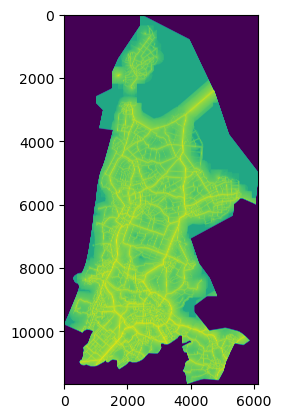

In [30]:
# Inspect whether clipping to North-Holland was successful
with rasterio.open('INFOMSSML raster data/processed_data/Noord-Holland_rivm_20220601_Geluid_lden_wegverkeer_2020.tif') as src:
    road_noise_nh = src.read()
    show(road_noise_nh)

### 3.2 Vector data

- no90_data to no21_data
- co90_data to co21_data
- landuse

In [31]:
raw_data_folder_path = 'INFOMSSML vector data/'

for file_name in os.listdir(raw_data_folder_path):
    # Check if the file is a gpkg or shp file
    if file_name.endswith(('.gpkg', '.shp')):
        print(f'Working on {file_name}')
        # Construct the full path to the file
        file_path = os.path.join(raw_data_folder_path, file_name)
        
        # Clip the vector data to the province of North-Holland
        temp_vector_data = gpd.read_file(file_path)
        temp_vector_data = temp_vector_data.to_crs(north_holland.crs)
        temp_clipped_vector_data = gpd.overlay(temp_vector_data, north_holland, how='intersection')

        # Define an appropriate output file name
        if not os.path.exists(raw_data_folder_path + 'processed_data'):
            os.makedirs(raw_data_folder_path + 'processed_data')
        # Export the clipped vector data        
        output_file_name = raw_data_folder_path + 'processed_data/' + 'Noord-Holland_' + file_name
        temp_clipped_vector_data.to_file(output_file_name, driver='GPKG')
        
        print(f'Clipped raster saved')

Working on bbg2017.gpkg
Clipped raster saved
Working on CO2_1990.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on CO2_1995.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on CO2_2000.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on CO2_2005.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on CO2_2010.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on CO2_2015.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on CO2_2019.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on CO2_2020.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on CO2_2021.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on NO2_1990.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on NO2_1995.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on NO2_2000.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on NO2_2005.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on NO2_2010.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on NO2_2015.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on NO2_2019.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on NO2_2020.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


Clipped raster saved
Working on NO2_2021.shp
Clipped raster saved


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: The filename extension should be 'gpkg' instead of 'shp' to conform to the GPKG specification.
  ogr_write(


<Axes: >

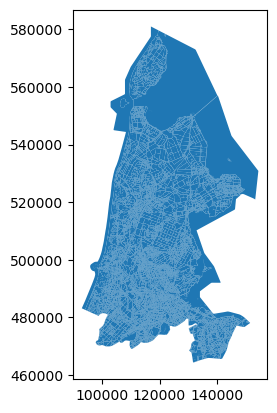

In [32]:
# Inspect whether clipping to North-Holland was successful (gpkg file)
landuse_nh_path = 'INFOMSSML vector data/processed_data/Noord-Holland_bbg2017.gpkg'
landuse_nh = gpd.read_file(landuse_nh_path)
landuse_nh.plot()

C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_CO2_1990.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(


<Axes: >

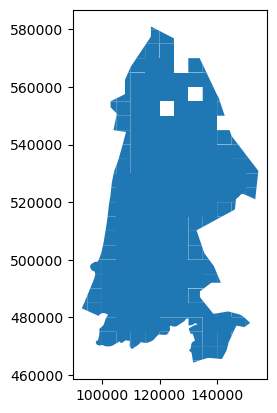

In [33]:
# Inspect whether clipping to North-Holland was successful (shp file)
co90_nh_path = 'INFOMSSML vector data/processed_data/Noord-Holland_CO2_1990.shp'
co90_nh = gpd.read_file(co90_nh_path)
co90_nh.plot()

## 4. Resample data to one resolution

First, examine the resolution of each dataset.
- road_noise_data: 10 by 10 m
- health_data: 25 by 25 m
- no2 and co2 data: **5 by 5 km**
- landuse: NA

### 4.1 Raster data

In [34]:
raw_data_folder_path = 'INFOMSSML raster data/processed_data/'
target_data_name = 'Noord-Holland_mgr_tot_2020_v2_13092023.tif'
target_data_path = os.path.join(raw_data_folder_path, target_data_name)

# Ensure the output directory exists
output_directory = os.path.join(raw_data_folder_path, 'resampled_data')
os.makedirs(output_directory, exist_ok=True)

# Open the target dataset to read its spatial characteristics
with rasterio.open(target_data_path) as target_dataset:
    target_crs = target_dataset.crs
    target_transform = target_dataset.transform
    target_width = target_dataset.width
    target_height = target_dataset.height

    for file_name in os.listdir(raw_data_folder_path):
        if file_name.endswith('.tif') and file_name != target_data_name:
            print(f'Working on {file_name}')
            file_path = os.path.join(raw_data_folder_path, file_name)

            with rasterio.open(file_path) as src:
                # Calculate the transform and dimensions for the output dataset to match the target
                transform, width, height = calculate_default_transform(
                    src.crs, target_crs, target_width, target_height, *src.bounds, dst_transform=target_transform
                )

                # Update metadata for the output dataset
                metadata = src.meta.copy()
                metadata.update({
                    'crs': target_crs,
                    'transform': target_transform,
                    'width': target_width,
                    'height': target_height,
                    'nodata': src.nodata or -9999,
                })

                output_file_name = os.path.join(output_directory, 'Noord-Holland_' + file_name)

                # Perform the reprojection/resampling
                with rasterio.open(output_file_name, 'w', **metadata) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=target_transform,
                            dst_crs=target_crs,
                            resampling=Resampling.bilinear
                        )

            print(f'Data successfully resampled and aligned: {output_file_name}')

Working on Noord-Holland_rivm_20220601_Geluid_lden_wegverkeer_2020.tif
Data successfully resampled and aligned: INFOMSSML raster data/processed_data/resampled_data\Noord-Holland_Noord-Holland_rivm_20220601_Geluid_lden_wegverkeer_2020.tif


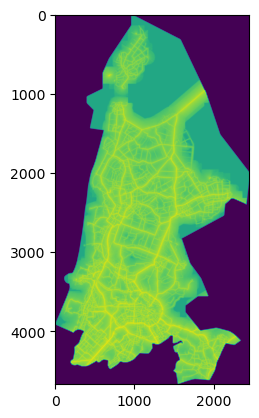

(25.0, 25.0)


In [35]:
# Inspect whether resampling was successful
with rasterio.open('INFOMSSML raster data/processed_data/resampled_data/Noord-Holland_Noord-Holland_rivm_20220601_Geluid_lden_wegverkeer_2020.tif') as src:
    health_nh_resampled = src.read()
    health_nh_resampled_res = src.res
    show(health_nh_resampled)
    print(health_nh_resampled_res)

### 4.2 Vector data

In [36]:
# Set the paths
raw_data_folder_path = 'INFOMSSML vector data/processed_data/'
target_data_path = 'INFOMSSML raster data/processed_data/Noord-Holland_mgr_tot_2020_v2_13092023.tif'

# Create an output directory for the resampled data
output_directory = os.path.join(raw_data_folder_path, 'resampled_data')
os.makedirs(output_directory, exist_ok=True)

# Open the target raster to get its spatial characteristics
with rasterio.open(target_data_path) as target:
    target_transform = target.transform
    target_width = target.width
    target_height = target.height
    target_crs = target.crs

for file_name in os.listdir(raw_data_folder_path):
    if file_name.endswith(('.gpkg', '.shp')):
        print(f'Working on {file_name}')
        name_without_extension, _ = os.path.splitext(file_name)
        file_path = os.path.join(raw_data_folder_path, file_name)

        # Load the vector data
        vector_data = gpd.read_file(file_path)

        # Determine which column to use based on file extension
        if file_name.endswith('.gpkg'):
            column_name = 'bg2017'
        elif file_name.endswith('.shp'):
            column_name = 'emision'
        else:
            print(f"Skipping {file_name}: unsupported file format.")
            continue

        # Ensure the vector data has the required column
        if column_name not in vector_data.columns:
            print(f"Skipping {file_name}: '{column_name}' column not found.")
            continue

        # Set output raster file path
        output_file_name = os.path.join(output_directory, f'Noord-Holland_{name_without_extension}.tif')

        # Define the output raster's metadata
        meta = {
            'driver': 'GTiff',
            'height': target_height,
            'width': target_width,
            'count': 1,
            'dtype': 'float32',
            'crs': target_crs,
            'transform': target_transform,
            'nodata': 0
        }

        # Prepare the shapes and values for rasterization
        shapes_and_values = [(geom, value) for geom, value in zip(vector_data.geometry, vector_data[column_name])]

        # Rasterize the vector data
        with rasterio.open(output_file_name, 'w', **meta) as out_raster:
            rasterized_layer = rasterize(
                shapes_and_values,
                out_shape=(target_height, target_width),
                transform=target_transform,
                fill=0,  # fill value for 'nodata'
                all_touched=True,
                dtype='float32'
            )
            out_raster.write(rasterized_layer, 1)  # Writing to band 1

        print(f'Data successfully rasterized and aligned: {output_file_name}')

Working on Noord-Holland_bbg2017.gpkg
Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_bbg2017.tif
Working on Noord-Holland_CO2_1990.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_CO2_1990.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(


Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_CO2_1990.tif
Working on Noord-Holland_CO2_1995.shp
Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_CO2_1995.tif
Working on Noord-Holland_CO2_2000.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_CO2_1995.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_CO2_2000.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(


Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_CO2_2000.tif
Working on Noord-Holland_CO2_2005.shp
Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_CO2_2005.tif
Working on Noord-Holland_CO2_2010.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_CO2_2005.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_CO2_2010.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(


Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_CO2_2010.tif
Working on Noord-Holland_CO2_2015.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_CO2_2015.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(


Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_CO2_2015.tif
Working on Noord-Holland_CO2_2019.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_CO2_2019.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(


Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_CO2_2019.tif
Working on Noord-Holland_CO2_2020.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_CO2_2020.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(


Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_CO2_2020.tif
Working on Noord-Holland_CO2_2021.shp
Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_CO2_2021.tif
Working on Noord-Holland_NO2_1990.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_CO2_2021.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_NO2_1990.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(


Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_NO2_1990.tif
Working on Noord-Holland_NO2_1995.shp
Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_NO2_1995.tif
Working on Noord-Holland_NO2_2000.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_NO2_1995.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_NO2_2000.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(


Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_NO2_2000.tif
Working on Noord-Holland_NO2_2005.shp
Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_NO2_2005.tif
Working on Noord-Holland_NO2_2010.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_NO2_2005.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_NO2_2010.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(


Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_NO2_2010.tif
Working on Noord-Holland_NO2_2015.shp
Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_NO2_2015.tif
Working on Noord-Holland_NO2_2019.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_NO2_2015.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_NO2_2019.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(


Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_NO2_2019.tif
Working on Noord-Holland_NO2_2020.shp
Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_NO2_2020.tif
Working on Noord-Holland_NO2_2021.shp


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_NO2_2020.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_NO2_2021.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(


Data successfully rasterized and aligned: INFOMSSML vector data/processed_data/resampled_data\Noord-Holland_Noord-Holland_NO2_2021.tif


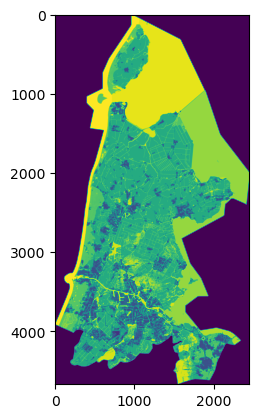

(25.0, 25.0)


In [37]:
# Inspect whether resampling was successful
with rasterio.open('INFOMSSML vector data/processed_data/resampled_data/Noord-Holland_Noord-Holland_bbg2017.tif') as src:
    landuse_raster_resampled = src.read()
    landuse_raster_resampled_res = src.res
    show(landuse_raster_resampled)
    print(landuse_raster_resampled_res)

## 5. CO2 and NO2 trade-off

The higher the trade-off value, the more NO2 and the less CO2 because you divide NO2 by CO2.

In [63]:
# Define the output folder path
output_folder = 'INFOMSSML vector data/processed_data/resampled_data/tradeoff'

# Create the output folder if it does not exist
os.makedirs(output_folder, exist_ok=True)

# Define all years for which data is available
years = [1990, 1995, 2000, 2005, 2010, 2015, 2019, 2020, 2021]

# Loop over each year
for year in years:
    # Construct the file paths for NO2, CO2, and output files
    no2_file_path = f'INFOMSSML vector data/processed_data/resampled_data/Noord-Holland_Noord-Holland_NO2_{year}.tif'
    co2_file_path = f'INFOMSSML vector data/processed_data/resampled_data/Noord-Holland_Noord-Holland_CO2_{year}.tif'
    output_file_path = os.path.join(output_folder, f'Noord-Holland_NO2_CO2_Tradeoff_{year}.tif')

    # Read the NO2 raster file and calculate its mean and standard deviation
    with rasterio.open(no2_file_path) as no2_src:
        no2 = no2_src.read(1).astype('float32')  # Read the first band
        no2_mean, no2_std = np.nanmean(no2), np.nanstd(no2)
        
        # Read the CO2 raster file and calculate its mean and standard deviation
        with rasterio.open(co2_file_path) as co2_src:
            co2 = co2_src.read(1).astype('float32')  # Read the first band
            co2_mean, co2_std = np.nanmean(co2), np.nanstd(co2)
            
            # Ensure both rasters have the same shape
            assert no2.shape == co2.shape, "The rasters do not have the same shape."
            
            # Apply Z-score normalization to NO2 and CO2 rasters
            no2_normalized = (no2 - no2_mean) / no2_std
            co2_normalized = (co2 - co2_mean) / co2_std
            
            # Perform the division operation
            with np.errstate(divide='ignore', invalid='ignore'):  # Ignore division by zero and invalid operations
                trade_off = np.true_divide(no2_normalized, co2_normalized)
                trade_off[~np.isfinite(trade_off)] = 0  # Replace infinities and NaNs with 0
            
            # Copy metadata from one of the inputs
            metadata = no2_src.meta.copy()

            # Update metadata for the output file (if needed)
            metadata.update({
                'dtype': 'float32',
                'count': 1,
            })

            # Write the result to a new raster file
            with rasterio.open(output_file_path, 'w', **metadata) as dst:
                dst.write(trade_off.astype('float32'), 1)
                
            print(f"Trade-off raster for {year} created successfully.")

Trade-off raster for 1990 created successfully.
Trade-off raster for 1995 created successfully.
Trade-off raster for 2000 created successfully.
Trade-off raster for 2005 created successfully.
Trade-off raster for 2010 created successfully.
Trade-off raster for 2015 created successfully.
Trade-off raster for 2019 created successfully.
Trade-off raster for 2020 created successfully.
Trade-off raster for 2021 created successfully.


## 6. Spatial ridge regression

### 6.1 North-Holland

#### 6.1.1 Feature engineering

In [7]:
# Define function to calculate zonal statistics
def calculate_zonal_stats(gdf, raster_file, categorical=False):
    with rasterio.open(raster_file) as src:
        affine = src.transform
        array = src.read(1)
        zonal_stats_df = pd.DataFrame(zonal_stats(gdf, array, affine=affine, categorical=categorical))
        return zonal_stats_df

# Define base folder
base_folder = "INFOMSSML final data"

# Dictionary to store GeoDataFrames for each year
gdf_dict = {}

# Loop over each year
for year in years:
    # Read vector data for NO2 and CO2 for the current year
    no2_file = f"INFOMSSML vector data/processed_data/Noord-Holland_NO2_{year}.shp"
    co2_file = f"INFOMSSML vector data/processed_data/Noord-Holland_CO2_{year}.shp"
    no2_gdf = gpd.read_file(no2_file)
    co2_gdf = gpd.read_file(co2_file)

    # Merge vector data
    gdf = no2_gdf.merge(co2_gdf[['ai_code', 'emision']], on='ai_code', how='inner', suffixes=['_no2', '_co2'])

    # Define file paths for raster data (These files remain constant for each year)
    mgr_file = os.path.join(base_folder, "Noord-Holland_mgr_tot_2020_v2_13092023.tif")
    sound_file = os.path.join(base_folder, "Noord-Holland_Noord-Holland_rivm_20220601_Geluid_lden_wegverkeer_2020.tif")
    bbg_file = os.path.join(base_folder, "Noord-Holland_Noord-Holland_bbg2017.tif")

    # Calculate zonal statistics for MGR file
    mgr_zonal_stats = calculate_zonal_stats(gdf, mgr_file)
    mgr_zonal_stats.rename(columns={'mean': 'mean_mgr'}, inplace=True)
    mgr_zonal_stats.drop(columns=['min', 'max', 'count'], inplace=True)

    # Calculate zonal statistics for Sound file
    sound_zonal_stats = calculate_zonal_stats(gdf, sound_file)
    sound_zonal_stats.rename(columns={'mean': 'mean_sound'}, inplace=True)
    sound_zonal_stats.drop(columns=['min', 'max', 'count'], inplace=True)

    # Calculate zonal statistics for BBG file
    bbg_zonal_stats = calculate_zonal_stats(gdf, bbg_file, categorical=True)
    bbg_zonal_stats.rename(columns={
        10: 'landuse_cat10',
        11: 'landuse_cat11',
        12: 'landuse_cat12',
        20: 'landuse_cat20',
        21: 'landuse_cat21',
        22: 'landuse_cat22',
        23: 'landuse_cat23',
        24: 'landuse_cat24',
        30: 'landuse_cat30',
        31: 'landuse_cat31',
        32: 'landuse_cat32',
        33: 'landuse_cat33',
        34: 'landuse_cat34',
        35: 'landuse_cat35',
        40: 'landuse_cat40',
        41: 'landuse_cat41',
        42: 'landuse_cat42',
        43: 'landuse_cat43',
        44: 'landuse_cat44',
        50: 'landuse_cat50',
        51: 'landuse_cat51',
        60: 'landuse_cat60',
        61: 'landuse_cat61',
        62: 'landuse_cat62',
        70: 'landuse_cat70',
        71: 'landuse_cat71',
        72: 'landuse_cat72',
        73: 'landuse_cat73',
        74: 'landuse_cat74',
        75: 'landuse_cat75',
        76: 'landuse_cat76',
        77: 'landuse_cat77',
        78: 'landuse_cat78',
        80: 'landuse_cat80',
        81: 'landuse_cat81',
        82: 'landuse_cat82',
        83: 'landuse_cat83',
        90: 'landuse_cat90'
    }, inplace=True)

    # Merge zonal statistics with main GeoDataFrame
    gdf = pd.concat([gdf, mgr_zonal_stats, sound_zonal_stats, bbg_zonal_stats], axis=1)

    # Calculate centroid and distance to AMS airport
    gdf['X'] = gdf['geometry'].centroid.x
    gdf['Y'] = gdf['geometry'].centroid.y
    schiphol_point = Point(112509.4747363544, 480192.655034324)
    gdf['distance_schiphol'] = gdf['geometry'].centroid.distance(schiphol_point)
    
    # Store GeoDataFrame in the dictionary
    gdf_dict[f'gdf_{year}'] = gdf

C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_NO2_1990.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_CO2_1990.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_NO2_1995.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML

#### 6.1.2 Regression inputs (X, y, coords)

In [8]:
# Initialize empty dictionaries to store GeoDataFrames, X, y, and coordinates for each year
gdf_dict1 = {}
X_dict = {}
y_dict = {}
coord_dict = {}

for year in years:
    # Access the GeoDataFrame for the current year
    gdf_year = gdf_dict[f'gdf_{year}']
    
    # Store the GeoDataFrame in the dictionary
    gdf_dict1[f'gdf_{year}'] = gdf_year
    
    # Extract y values
    y = gdf_year['emision_no2'].values.reshape((-1, 1))
    y_dict[f'y_{year}'] = y
    
    # Extract X values
    X = gdf_year[['emision_co2', 'mean_mgr', 'mean_sound', 'landuse_cat11',
                  'landuse_cat33', 'landuse_cat44', 'landuse_cat51', 'landuse_cat60',
                  'landuse_cat61', 'landuse_cat62', 'landuse_cat78', 'landuse_cat83',
                  'landuse_cat20', 'landuse_cat22', 'landuse_cat23', 'landuse_cat24',
                  'landuse_cat32', 'landuse_cat34', 'landuse_cat40', 'landuse_cat41',
                  'landuse_cat42', 'landuse_cat50', 'landuse_cat21', 'landuse_cat31',
                  'landuse_cat43', 'landuse_cat75', 'landuse_cat70', 'landuse_cat35',
                  'landuse_cat74', 'landuse_cat10', 'landuse_cat30', 'landuse_cat12',
                  'landuse_cat80', 'landuse_cat77', 'landuse_cat73',
                  'distance_schiphol']].values
    X = np.nan_to_num(X, nan=0)  # Replace NaN values with 0
    X_dict[f'X_{year}'] = X
    
    # Extract coordinates
    u = gdf_year['X']
    v = gdf_year['Y']
    coord = list(zip(u, v))
    coord_dict[f'coord_{year}'] = coord

# Access the data for each year using the dictionaries
# For example, to access data for the year 1990:
print(gdf_dict1['gdf_1990'].head())
print(y_dict['y_1990'])
print(X_dict['X_1990'])
print(coord_dict['coord_1990'])

  ai_code                 substance  year    emision_no2 unit  OBJECTID  \
0  100525  Stikstofoxiden (als NO2)  1990    8225.175874   kg         8   
1  105525  Stikstofoxiden (als NO2)  1990  169199.385653   kg         8   
2  110525  Stikstofoxiden (als NO2)  1990  216452.585303   kg         8   
3  115525  Stikstofoxiden (als NO2)  1990  172715.096675   kg         8   
4  120525  Stikstofoxiden (als NO2)  1990  192565.750068   kg         8   

   PROVINCIENAAM PROV_CODE    SHAPE_AREA      SHAPE_LEN  ... landuse_cat74  \
0  Noord-Holland        27  4.092688e+09  380179.016742  ...           NaN   
1  Noord-Holland        27  4.092688e+09  380179.016742  ...           NaN   
2  Noord-Holland        27  4.092688e+09  380179.016742  ...           NaN   
3  Noord-Holland        27  4.092688e+09  380179.016742  ...           NaN   
4  Noord-Holland        27  4.092688e+09  380179.016742  ...           NaN   

   landuse_cat10  landuse_cat30  landuse_cat12  landuse_cat80  landuse_cat77  \


#### 6.1.3 Principal Component Analysis (PCA)

In [9]:
X = X_dict['X_1990']
X.shape

(202, 36)

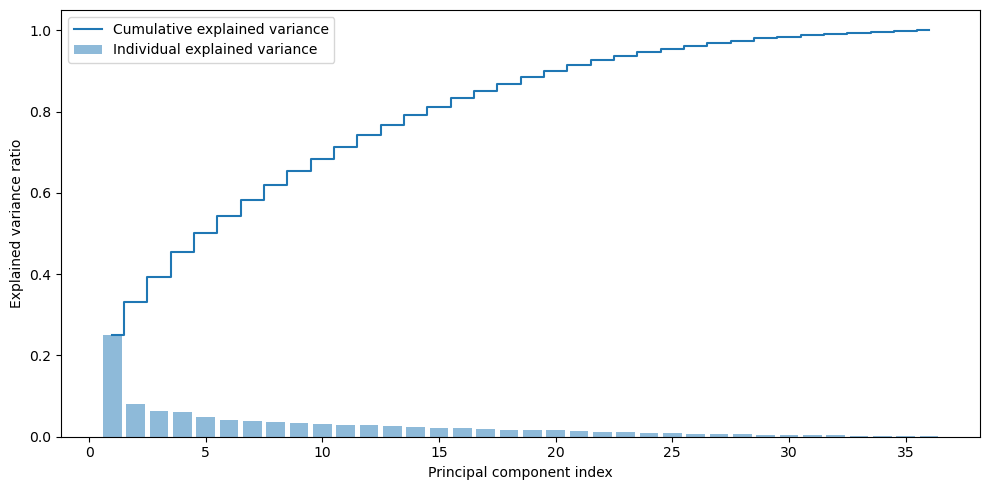

Number of components to explain 90% of variance: 20


In [10]:
# Standardizing the features
X_standardized = StandardScaler().fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_standardized)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plotting the explained variance and cumulative explained variance
plt.figure(figsize=(10, 5))

plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid',
         label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Decision based on cumulative explained variance
for i, cum_var in enumerate(cumulative_explained_variance, start=1):
    if cum_var >= 0.90:
        print(f"Number of components to explain 90% of variance: {i}")
        break

#### 6.1.4 NO2 prediction

In [47]:
yearly_summary_NH = {}

# Define the parameter grid for alpha
param_grid = {'alpha': [0.1, 1.0, 10.0]}  # parameter tuning with grid search

# Define the number of folds for spatial k-fold cross-validation
n_splits = 5

for year in years:
    # Access X and y data for the current year
    X = X_dict[f'X_{year}']
    y = y_dict[f'y_{year}']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Perform PCA on the train set
    pca = PCA(n_components=20)
    X_train_pca = pca.fit_transform(X_train)

    # Create Ridge regression model
    ridge = Ridge()

    # Initialize spatial k-fold cross-validation
    spatial_kfold = KFold(n_splits=n_splits, shuffle=True)

    # Perform grid search with spatial k-fold cross-validation
    grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=spatial_kfold)
    grid_search.fit(X_train_pca, y_train)

    # Get the best alpha value
    best_alpha = grid_search.best_params_['alpha']

    # Create Ridge regression model with the best alpha
    ridge_model = Ridge(alpha=best_alpha)
    ridge_model.fit(X_train_pca, y_train)

    # Perform PCA transformation on test set
    X_test_pca = pca.transform(X_test)

    # Predict on the test set
    y_pred = ridge_model.predict(X_test_pca)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results in yearly_summary_NH dictionary
    yearly_summary_NH[year] = {
        'best_alpha': best_alpha,
        'MSE': mse,
        'R_squared': r2,
        'coefficients': ridge_model.coef_
    }

    print(f"Evaluation metrics for year {year}:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print(f"Best alpha found by grid search: {best_alpha}")

Evaluation metrics for year 1990:
Mean Squared Error: 1947777560924.0042
R-squared: 0.6061866579487151
Best alpha found by grid search: 10.0
Evaluation metrics for year 1995:
Mean Squared Error: 191194736765.10736
R-squared: 0.9543012014240984
Best alpha found by grid search: 0.1
Evaluation metrics for year 2000:
Mean Squared Error: 524931580110.78314
R-squared: 0.7576552866803552
Best alpha found by grid search: 0.1
Evaluation metrics for year 2005:
Mean Squared Error: 1074908030354.3832
R-squared: 0.5543391103633748
Best alpha found by grid search: 0.1
Evaluation metrics for year 2010:
Mean Squared Error: 105215163848.8751
R-squared: 0.93331066464378
Best alpha found by grid search: 0.1
Evaluation metrics for year 2015:
Mean Squared Error: 246458363929.14572
R-squared: 0.8242496135191835
Best alpha found by grid search: 10.0
Evaluation metrics for year 2019:
Mean Squared Error: 186399853856.19595
R-squared: 0.8587942817812229
Best alpha found by grid search: 10.0
Evaluation metrics f

### 6.2 Amsterdam Airport Schiphol area

#### 6.2.1 Clip data to AMS airport polygon

In [13]:
# Define file paths for raster data
base_folder = "INFOMSSML final data"
output_folder = os.path.join(base_folder, "AMS")

# Create the output folder if it does not exist
os.makedirs(output_folder, exist_ok=True)

# Load shapefile of a defined area around AMS airport
polygon_gdf = gpd.read_file("Luchthaventerrein/schiphol_area.shp")

# List all .tif files in the raster folder
tif_files = [f for f in os.listdir(base_folder) if f.endswith('.tif')]

# Loop through each raster file
for tif_file in tif_files:
    # Construct full path to the raster file
    rasterfile_path = os.path.join(base_folder, tif_file)

    # Open raster file
    with rasterio.open(rasterfile_path) as src:
        # Clip the raster with the polygon extent
        clipped_raster, clipped_transform = mask(src, polygon_gdf.geometry, crop=True)

        # Get metadata of the clipped raster
        clipped_meta = src.meta.copy()
        clipped_meta.update({
            "driver": "GTiff",
            "height": clipped_raster.shape[1],
            "width": clipped_raster.shape[2],
            "transform": clipped_transform
        })

    # Save the clipped raster
    clipped_output_path = os.path.join(output_folder, tif_file.replace('.tif', '_AMS.tif'))
    with rasterio.open(clipped_output_path, "w", **clipped_meta) as dest:
        dest.write(clipped_raster)

    print("Clipping completed and saved to", clipped_output_path)

Clipping completed and saved to INFOMSSML final data\AMS\Noord-Holland_mgr_tot_2020_v2_13092023_AMS.tif
Clipping completed and saved to INFOMSSML final data\AMS\Noord-Holland_Noord-Holland_bbg2017_AMS.tif
Clipping completed and saved to INFOMSSML final data\AMS\Noord-Holland_Noord-Holland_CO2_1990_AMS.tif
Clipping completed and saved to INFOMSSML final data\AMS\Noord-Holland_Noord-Holland_CO2_1995_AMS.tif
Clipping completed and saved to INFOMSSML final data\AMS\Noord-Holland_Noord-Holland_CO2_2000_AMS.tif
Clipping completed and saved to INFOMSSML final data\AMS\Noord-Holland_Noord-Holland_CO2_2005_AMS.tif
Clipping completed and saved to INFOMSSML final data\AMS\Noord-Holland_Noord-Holland_CO2_2010_AMS.tif
Clipping completed and saved to INFOMSSML final data\AMS\Noord-Holland_Noord-Holland_CO2_2015_AMS.tif
Clipping completed and saved to INFOMSSML final data\AMS\Noord-Holland_Noord-Holland_CO2_2019_AMS.tif
Clipping completed and saved to INFOMSSML final data\AMS\Noord-Holland_Noord-Holl

In [14]:
# Define base folder
base_folder = "INFOMSSML vector data"

# Load the shapefile of the area around AMS airport
polygon_gdf = gpd.read_file("Luchthaventerrein/schiphol_area.shp")

# Create the output folder if it does not exist
clipped_folder = os.path.join(base_folder, "clipped_data")
os.makedirs(clipped_folder, exist_ok=True)

# Iterate over each year
for year in years:
    # Define the file paths for the shapefiles to be clipped
    no2_file = f"INFOMSSML vector data/processed_data/Noord-Holland_NO2_{year}.shp"
    co2_file = f"INFOMSSML vector data/processed_data/Noord-Holland_CO2_{year}.shp"

    # Read the shapefiles to be clipped
    no2_gdf = gpd.read_file(no2_file)
    co2_gdf = gpd.read_file(co2_file)

    # Clip the shapefiles to the extent of the polygon
    clipped_no2_gdf = gpd.clip(no2_gdf, polygon_gdf.geometry)
    clipped_co2_gdf = gpd.clip(co2_gdf, polygon_gdf.geometry)

    # Save the clipped shapefiles
    clipped_no2_file = os.path.join(clipped_folder, f"Noord-Holland_NO2_{year}_clipped.shp")
    clipped_co2_file = os.path.join(clipped_folder, f"Noord-Holland_CO2_{year}_clipped.shp")

    clipped_no2_gdf.to_file(clipped_no2_file)
    clipped_co2_gdf.to_file(clipped_co2_file)

    print("Clipping completed and saved for year", year)

C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_NO2_1990.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_CO2_1990.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(
C:\Users\inge3\AppData\Local\Temp\ipykernel_25440\1786127732.py:29: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_no2_gdf.to_file(clipped_no2_file)
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Normalized/laundered field name: 'PROVINCIENAAM' to 'PROVINCIEN'
  ogr_write(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Value 4092688018.42760992 of field S

Clipping completed and saved for year 1990
Clipping completed and saved for year 1995
Clipping completed and saved for year 2000


C:\Users\inge3\AppData\Local\Temp\ipykernel_25440\1786127732.py:29: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_no2_gdf.to_file(clipped_no2_file)
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Normalized/laundered field name: 'PROVINCIENAAM' to 'PROVINCIEN'
  ogr_write(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Value 4092688018.42760992 of field SHAPE_AREA of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Value 4092688018.42760992 of field SHAPE_AREA of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Value 40926880

Clipping completed and saved for year 2005
Clipping completed and saved for year 2010
Clipping completed and saved for year 2015


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: File INFOMSSML vector data/processed_data/Noord-Holland_CO2_2015.shp has GPKG application_id, but non conformant file extension
  result = ogr_read(
C:\Users\inge3\AppData\Local\Temp\ipykernel_25440\1786127732.py:29: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_no2_gdf.to_file(clipped_no2_file)
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Normalized/laundered field name: 'PROVINCIENAAM' to 'PROVINCIEN'
  ogr_write(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Value 4092688018.42760992 of field SHAPE_AREA of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Value 4092688018.42760992

Clipping completed and saved for year 2019
Clipping completed and saved for year 2020
Clipping completed and saved for year 2021


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Normalized/laundered field name: 'PROVINCIENAAM' to 'PROVINCIEN'
  ogr_write(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Value 190610332.422024608 of field emision of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Value 4092688018.42760992 of field SHAPE_AREA of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Value 4092688018.42760992 of field SHAPE_AREA of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\pyogrio\raw

#### 6.2.2 Feature engineering

In [15]:
# Define base folder
base_folder = "INFOMSSML final data/AMS"

# Dictionary to store GeoDataFrames for each year
gdf_dict_AMS = {}

# Loop over each year
for year in years:
    # Read vector data for NO2 and CO2 for the current year
    no2_file = f"INFOMSSML vector data/clipped_data/Noord-Holland_NO2_{year}_clipped.shp"
    co2_file = f"INFOMSSML vector data/clipped_data/Noord-Holland_CO2_{year}_clipped.shp"
    no2_gdf = gpd.read_file(no2_file)
    co2_gdf = gpd.read_file(co2_file)

    # Merge vector data
    gdf = no2_gdf.merge(co2_gdf[['ai_code', 'emision']], on='ai_code', how='inner', suffixes=['_no2', '_co2'])

    # Define file paths for raster data (These files remain constant for each year)
    mgr_file = os.path.join(base_folder, "Noord-Holland_mgr_tot_2020_v2_13092023_AMS.tif")
    sound_file = os.path.join(base_folder, "Noord-Holland_Noord-Holland_rivm_20220601_Geluid_lden_wegverkeer_2020_AMS.tif")
    bbg_file = os.path.join(base_folder, "Noord-Holland_Noord-Holland_bbg2017_AMS.tif")

    # Calculate zonal statistics for MGR file
    mgr_zonal_stats = calculate_zonal_stats(gdf, mgr_file)
    mgr_zonal_stats.rename(columns={'mean': 'mean_mgr'}, inplace=True)
    mgr_zonal_stats.drop(columns=['min', 'max', 'count'], inplace=True)

    # Calculate zonal statistics for Sound file
    sound_zonal_stats = calculate_zonal_stats(gdf, sound_file)
    sound_zonal_stats.rename(columns={'mean': 'mean_sound'}, inplace=True)
    sound_zonal_stats.drop(columns=['min', 'max', 'count'], inplace=True)

    # Calculate zonal statistics for BBG file
    bbg_zonal_stats = calculate_zonal_stats(gdf, bbg_file, categorical=True)
    bbg_zonal_stats.rename(columns={
        10: 'landuse_cat10',
        11: 'landuse_cat11',
        12: 'landuse_cat12',
        20: 'landuse_cat20',
        21: 'landuse_cat21',
        22: 'landuse_cat22',
        23: 'landuse_cat23',
        24: 'landuse_cat24',
        30: 'landuse_cat30',
        31: 'landuse_cat31',
        32: 'landuse_cat32',
        33: 'landuse_cat33',
        34: 'landuse_cat34',
        35: 'landuse_cat35',
        40: 'landuse_cat40',
        41: 'landuse_cat41',
        42: 'landuse_cat42',
        43: 'landuse_cat43',
        44: 'landuse_cat44',
        50: 'landuse_cat50',
        51: 'landuse_cat51',
        60: 'landuse_cat60',
        61: 'landuse_cat61',
        62: 'landuse_cat62',
        70: 'landuse_cat70',
        71: 'landuse_cat71',
        72: 'landuse_cat72',
        73: 'landuse_cat73',
        74: 'landuse_cat74',
        75: 'landuse_cat75',
        76: 'landuse_cat76',
        77: 'landuse_cat77',
        78: 'landuse_cat78',
        80: 'landuse_cat80',
        81: 'landuse_cat81',
        82: 'landuse_cat82',
        83: 'landuse_cat83',
        90: 'landuse_cat90'
    }, inplace=True)

    # Merge zonal statistics with main GeoDataFrame
    gdf = pd.concat([gdf, mgr_zonal_stats, sound_zonal_stats, bbg_zonal_stats], axis=1)

    # Calculate centroid and distance to AMS airport
    gdf['X'] = gdf['geometry'].centroid.x
    gdf['Y'] = gdf['geometry'].centroid.y
    schiphol_point = Point(112509.4747363544, 480192.655034324)
    gdf['distance_schiphol'] = gdf['geometry'].centroid.distance(schiphol_point)
    
    # Store GeoDataFrame in the dictionary
    gdf_dict_AMS[f'gdf_{year}'] = gdf

In [16]:
df = gdf_dict_AMS['gdf_1990'].head()
df.columns

Index(['ai_code', 'substance', 'year', 'emision_no2', 'unit', 'OBJECTID',
       'PROVINCIEN', 'PROV_CODE', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry',
       'emision_co2', 'mean_mgr', 'mean_sound', 'landuse_cat10',
       'landuse_cat11', 'landuse_cat20', 'landuse_cat21', 'landuse_cat22',
       'landuse_cat23', 'landuse_cat24', 'landuse_cat32', 'landuse_cat34',
       'landuse_cat40', 'landuse_cat41', 'landuse_cat42', 'landuse_cat43',
       'landuse_cat50', 'landuse_cat51', 'landuse_cat60', 'landuse_cat62',
       'landuse_cat75', 'landuse_cat78', 'landuse_cat12', 'landuse_cat61',
       'landuse_cat31', 'landuse_cat44', 'X', 'Y', 'distance_schiphol'],
      dtype='object')

#### 6.2.3 Regression inputs (X, y, coords)

In [17]:
# Initialize empty dictionaries to store GeoDataFrames, X, y, and coordinates for each year
gdf_dict_AMS1 = {}
X_dict_AMS = {}
y_dict_AMS = {}
coord_dict_AMS = {}

for year in years:
    # Access the GeoDataFrame for the current year
    gdf_year = gdf_dict_AMS[f'gdf_{year}']
    
    # Store the GeoDataFrame in the dictionary
    gdf_dict_AMS1[f'gdf_{year}'] = gdf_year
    
    # Extract y values
    y = gdf_year['emision_no2'].values.reshape((-1, 1))
    y_dict_AMS[f'y_{year}'] = y
    
    # Extract X values
    X = gdf_year[['emision_co2', 'mean_mgr', 'mean_sound', 'landuse_cat10',
       'landuse_cat11', 'landuse_cat20', 'landuse_cat21', 'landuse_cat22',
       'landuse_cat23', 'landuse_cat24', 'landuse_cat32', 'landuse_cat34',
       'landuse_cat40', 'landuse_cat41', 'landuse_cat42', 'landuse_cat43',
       'landuse_cat50', 'landuse_cat51', 'landuse_cat60', 'landuse_cat62',
       'landuse_cat75', 'landuse_cat78', 'landuse_cat12', 'landuse_cat61',
       'landuse_cat31', 'landuse_cat44', 'distance_schiphol']].values
    X = np.nan_to_num(X, nan=0)  # Replace NaN values with 0
    X_dict_AMS[f'X_{year}'] = X
    
    # Extract coordinates
    u = gdf_year['X']
    v = gdf_year['Y']
    coord = list(zip(u, v))
    coord_dict_AMS[f'coord_{year}'] = coord

# Access the data for each year using the dictionaries
# For example, to access data for the year 1990:
print(gdf_dict_AMS1['gdf_1990'].head())
print(y_dict_AMS['y_1990'])
print(X_dict_AMS['X_1990'])
print(coord_dict_AMS['coord_1990'])

  ai_code                 substance  year   emision_no2 unit  OBJECTID  \
0  105475  Stikstofoxiden (als NO2)  1990  9.051342e+05   kg         8   
1  105480  Stikstofoxiden (als NO2)  1990  3.754463e+05   kg         8   
2  115480  Stikstofoxiden (als NO2)  1990  2.064648e+06   kg         8   
3  115485  Stikstofoxiden (als NO2)  1990  2.794562e+06   kg         8   
4  115475  Stikstofoxiden (als NO2)  1990  9.057868e+05   kg         8   

      PROVINCIEN PROV_CODE    SHAPE_AREA      SHAPE_LEN  ... landuse_cat62  \
0  Noord-Holland        27  4.092688e+09  380179.016742  ...         458.0   
1  Noord-Holland        27  4.092688e+09  380179.016742  ...          26.0   
2  Noord-Holland        27  4.092688e+09  380179.016742  ...         360.0   
3  Noord-Holland        27  4.092688e+09  380179.016742  ...         204.0   
4  Noord-Holland        27  4.092688e+09  380179.016742  ...         790.0   

   landuse_cat75  landuse_cat78  landuse_cat12  landuse_cat61  landuse_cat31  \
0     

#### 6.2.4 Principal Component Analysis (PCA)

In [18]:
X_AMS = X_dict_AMS['X_1990']
X_AMS.shape

(9, 27)

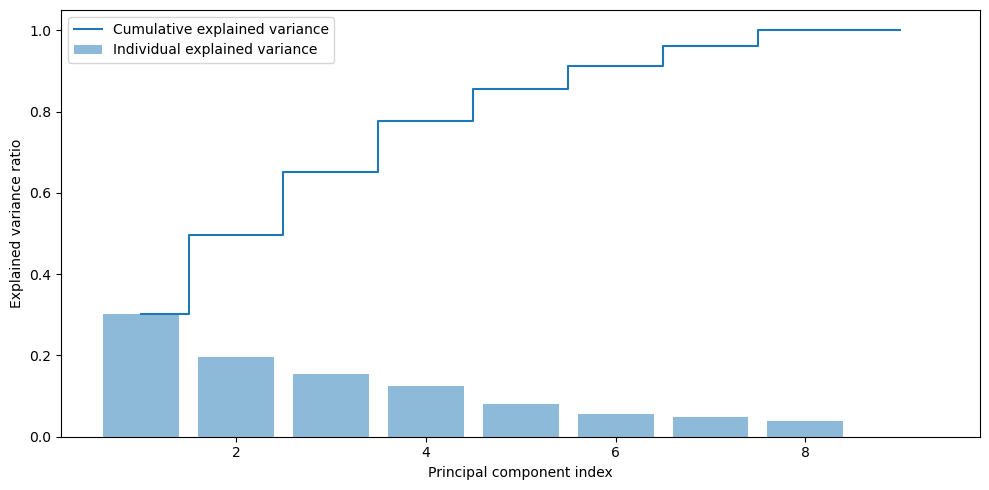

Number of components to explain 90% of variance: 6


In [19]:
# Standardizing the features
X_AMS_standardized = StandardScaler().fit_transform(X_AMS)

# PCA
pca = PCA()
X_AMS_pca = pca.fit_transform(X_AMS_standardized)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plotting the explained variance and cumulative explained variance
plt.figure(figsize=(10, 5))

plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid',
         label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Decision based on cumulative explained variance
for i, cum_var in enumerate(cumulative_explained_variance, start=1):
    if cum_var >= 0.90:
        print(f"Number of components to explain 90% of variance: {i}")
        break

#### 6.2.5 NO2 predictions

In [57]:
yearly_summary_AMS = {}

# Define the parameter grid for alpha
param_grid = {'alpha': [0.1, 1.0, 10.0]} # parameter tuning with grid search

# Define the number of folds for spatial k-fold cross-validation
n_splits = 5

for year in years:
    # Access X and y data for the current year
    X = X_dict_AMS[f'X_{year}']
    y = y_dict_AMS[f'y_{year}']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Perform PCA
    pca = PCA(n_components=6)
    X_pca = pca.fit_transform(X)

    # Create Ridge regression model
    ridge = Ridge()

    # Initialize spatial k-fold cross-validation
    spatial_kfold = KFold(n_splits=n_splits, shuffle=True)

    # Perform grid search
    grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=spatial_kfold)
    grid_search.fit(X_pca, y)

    # Get the best alpha value
    best_alpha = grid_search.best_params_['alpha']

    # Create Ridge regression model with the best alpha
    ridge_model = Ridge(alpha=best_alpha)
    ridge_model.fit(X_pca, y)

    # Predict on the same data
    y_pred = ridge_model.predict(X_pca)

    # Calculate evaluation metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Store the results in yearly_summary_AMS dictionary
    yearly_summary_AMS[year] = {
        'best_alpha': best_alpha,
        'MSE': mse,
        'R_squared': r2,
        'coefficients': ridge_model.coef_
    }

    print(f"Evaluation metrics for year {year}:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print(f"Best alpha found by grid search: {best_alpha}")

Evaluation metrics for year 1990:
Mean Squared Error: 30740998333.815628
R-squared: 0.9572206527379689
Best alpha found by grid search: 10.0
Evaluation metrics for year 1995:
Mean Squared Error: 316118082.22174245
R-squared: 0.9996042677566429
Best alpha found by grid search: 10.0
Evaluation metrics for year 2000:
Mean Squared Error: 15695202233.689938
R-squared: 0.9844480998840356
Best alpha found by grid search: 10.0
Evaluation metrics for year 2005:
Mean Squared Error: 1506120353.0040731
R-squared: 0.9985835273168835
Best alpha found by grid search: 10.0
Evaluation metrics for year 2010:
Mean Squared Error: 4256344921.6226707
R-squared: 0.9954506504087407
Best alpha found by grid search: 10.0


C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.2618e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.41533e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\inge3\anaconda3\envs\INFOMSSML\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.95056e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Evaluation metrics for year 2015:
Mean Squared Error: 1116639171.1982503
R-squared: 0.9902948337997574
Best alpha found by grid search: 10.0
Evaluation metrics for year 2019:
Mean Squared Error: 442754557.9024841
R-squared: 0.9968854869919196
Best alpha found by grid search: 10.0
Evaluation metrics for year 2020:
Mean Squared Error: 36004510.10935851
R-squared: 0.9992503190847127
Best alpha found by grid search: 10.0
Evaluation metrics for year 2021:
Mean Squared Error: 93824508.2291458
R-squared: 0.9983185591805716
Best alpha found by grid search: 10.0


### 6.3 R-squared comparison between NH and AMS models

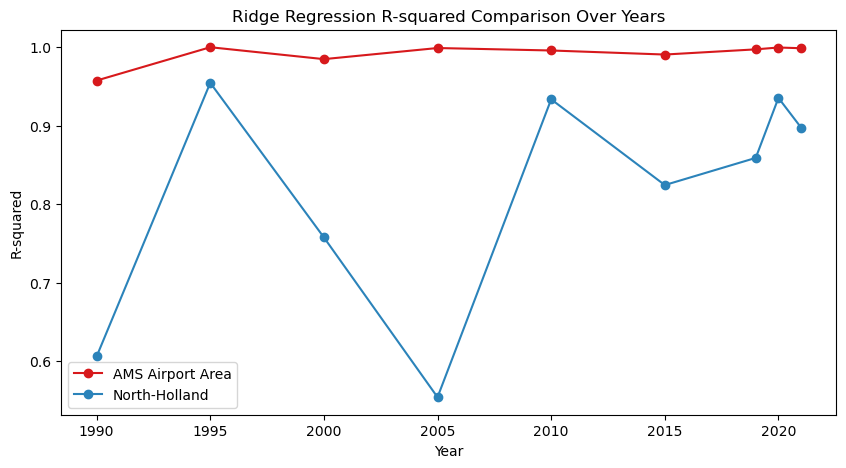

In [67]:
# Extract all years
years = sorted(yearly_summary_AMS.keys())

# Plotting R-squared values over the years
plt.figure(figsize=(10, 5))
r_squared_AMS = [yearly_summary_AMS[year]['R_squared'] for year in years]
r_squared_NH = [yearly_summary_NH[year]['R_squared'] for year in years]

plt.plot(years, r_squared_AMS, label='AMS Airport Area', marker='o', color='#D7191C')
plt.plot(years, r_squared_NH, label='North-Holland', marker='o', color='#2B83BA')

plt.xlabel('Year')
plt.ylabel('R-squared')
plt.title('Ridge Regression R-squared Comparison Over Years')
plt.legend()
plt.show()


## 7. Geographically Weighted Regression

See other *.py* notebook run in Spyder due to memory issues.